# Naive Bayes

## Setup

### Run the Data Evaluation notebook once to import the show_evaluation method

In [1]:
#refernce to data_evaluation notebook to use the show_evaluation function
%run data_evaluation.ipynb

### Imports

In [2]:
import os
import os.path
import numpy as np
import pandas as pd
import itertools

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

### Preprocessing Function

In [3]:
# Future Improvement Ideas
"""
This method provides a preprocessed data set.

Parameters:
enable_feature_engineering_gender (bool): describes whether the gender column (categorical) gets replaced by is_female (bool)
    True - enabled
    False - disabled
    
enable_feature_engineering_height_weight (bool): describes whether the height and weight column get replaced by bmi 
    True - enabled
    False - disabled  
    
enable_feature_engineering_gluc_chol (bool): describes whether the gluc and chol column get replaced by known_health_issues 
    True - enabled
    False - disabled  
    
enable_feature_engineering_alco_smoking (bool): describes whether the alcohol and smoking column get replaced by unhealthy_lifestyle 
    True - enabled
    False - disabled  
        
enable_outlier_handling (bool): describes whether some extreme data entries will be deleted or not, possbible values:
    True - enabled
    False - disabled
    
normalize (str): describes whether the numeric values should be normalized (between 0 and 1), possible values:
    'minmax' - uses min max to normalize the data
    'median' - uses median to normalize the data
    None - data won't be normalized

use_one_hot_encoding (bool): describes whether one hot encoding should be applied to categorical data, possible values are:
    True  - enabled
    False - disabled
    
split_size tuple(numeric, numeric, numeric): describes which porportion of the data should be used for the split, possible values:
    the input should be tuple with three numeric values which sum up to 1
        -> (0.7, 0.2, 0.1) in this case 70% will be used for training, 20% for validation and 10% for testing
    In case you want to use more complex cross validation algorithms like k-fold you should only split into train
    and apply your cross validation algorithm to the train data
    
Returns: 
(df): train set (y)
(df): train set (x)
(df): validation set (y)
(df): validation set (x)
(df): test set (y)
(df): test set (x)
"""
def get_data(enable_feature_engineering_gender, enable_feature_engineering_height_weight, enable_feature_engineering_gluc_chol, enable_feature_engineering_alco_smoking, enable_outlier_handling, normalize, enable_one_hot_encoding, split_size):
    # load the data
    data_file_folder = 'data'
    data_file_name = 'cardio_data.csv' 
    data_df = pd.read_csv(os.path.join('..' , data_file_folder, data_file_name), sep=';')       
      
    # drop unnecessary columns
    data_df = data_df.drop(['id'], axis=1)   
            
    # set dtypes
    data_df = data_df.astype({
        'age': 'int64',
        'gender': 'int64',
        'height': 'int64',
        'weight': 'int64',
        'ap_hi': 'int64',
        'ap_lo': 'int64',
        'cholesterol': 'int64',
        'gluc': 'int64',
        'smoke': 'bool',
        'alco': 'bool',
        'active': 'bool',
        'cardio': 'bool'
    })
    
    # drop duplicate rows
    before = data_df.shape[0]
    data_df.drop_duplicates(inplace=True)
    after = data_df.shape[0]
    print(f'Dropped {before - after} duplicate rows.')
    
    # outlier handline
    if enable_outlier_handling:
        # remove extreme cases of height, weight and blood presure (height, weight, ap_hi, ap_lo)
        before = data_df.shape[0]
        data_df = data_df[data_df['height'] > 150]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> height too low.')
        
        before = data_df.shape[0]
        data_df = data_df[data_df['height'] < 250]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> height too high.')
        
        before = data_df.shape[0]
        data_df = data_df[data_df['weight'] > 35]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> weight too low.')
                
        before = data_df.shape[0]
        data_df = data_df[data_df['weight'] < 250]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> weight too high.')
       
        # normal systolic blood preasure ranges from ~80 to ~120 but values till 240(?) are imaginable                    
        before = data_df.shape[0]
        data_df = data_df[data_df['ap_hi'] > 40]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> systolic bp too low.')
                
        before = data_df.shape[0]
        data_df = data_df[data_df['ap_hi'] < 240]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> systolic bp too high.')
        
        # normal diastolic blood preasure ranges from ~40 to ~80  but values till 200(?) are imaginable
        before = data_df.shape[0]
        data_df = data_df[data_df['ap_lo'] > 20]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> diastolic bp too low.')
                
        before = data_df.shape[0]
        data_df = data_df[data_df['ap_lo'] < 220]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> diastolic bp too high.')
        
        # systolic blood preasure should always be higher then diastolic
        before = data_df.shape[0]
        data_df = data_df[data_df['ap_lo'] < data_df['ap_hi']]
        after = data_df.shape[0]
        
        print(f'Dropped {before - after} rows -> sytolic bp was lower than diastolic.')
        
    # feature engineering
    if enable_feature_engineering_gender:
        # replace gender with is female
        data_df['is_female'] = data_df['gender'] == 1
        data_df.drop(['gender'], axis=1, inplace=True)
        
    if enable_feature_engineering_height_weight:
        # combine height and weight to BMI to reduce the multicollinearity problem
        data_df['bmi'] = data_df['weight']/((data_df['height']/100)**2)
        data_df.drop(['height', 'weight'], axis=1, inplace=True)
        data_df = data_df.astype({'bmi': 'int64'})
        
    if enable_feature_engineering_alco_smoking:
        # combine alcohol and smoking to unhealthy_lifestyle
        data_df['unhealthy_lifestyle'] = data_df['alco'] + data_df['smoke'] < 0
        data_df.drop(['alco', 'smoke'], axis=1, inplace=True)
        
    if enable_feature_engineering_gluc_chol:
        # combine gluc and cholesterol to known_health_issues
        data_df['known_health_issues'] = data_df['gluc'] + data_df['cholesterol'] - 1
        data_df.drop(['gluc', 'cholesterol'], axis=1, inplace=True)
    
    #transforming the blood pressures values into categorical values low, normal, high 
    data_df['ap_lo_cat'] = pd.Series(np.random.randn(len(data_df['ap_lo'])), index=data_df.index)
    data_df['ap_hi_cat'] = pd.Series(np.random.randn(len(data_df['ap_hi'])), index=data_df.index)
    
    cut_labels = ['0', '1', '2']
    cut_bins = [0, 40, 80, data_df['ap_lo'].max()]
    data_df['ap_lo_cat'] = pd.cut(data_df['ap_lo'], bins=cut_bins, labels=cut_labels)
    
    cut_labels = ['0', '1', '2']
    cut_bins = [0, 80, 120, data_df['ap_hi'].max() ]
    data_df['ap_hi_cat'] = pd.cut(data_df['ap_hi'], bins=cut_bins, labels=cut_labels)
    
    data_df.drop(['ap_lo', 'ap_hi'], axis=1, inplace=True)
    data_df = data_df.astype({'ap_lo_cat': 'int64'})
    data_df = data_df.astype({'ap_hi_cat': 'int64'})
    
    # normalization
    if normalize is None:
        pass    
    elif normalize in ['minmax']:
        columns_to_normalize = ['age']
        
        if not enable_feature_engineering_height_weight:
            columns_to_normalize.append('height')
            columns_to_normalize.append('weight')
#         else:
#             columns_to_normalize.append('bmi')
        
        for column_name in columns_to_normalize:
            if normalize == 'minmax':
                data_df[column_name] = ((data_df[column_name] - data_df[column_name].min()) / (data_df[column_name].max() - data_df[column_name].min())).astype('float64')
    else:
        raise Exception('Invalid value for normalization!')
        

    
     # encoding (0 corresponds to healthy and 1 to having a cardio disease)       
    # this part also splits in x and y, it was convienient to do at one step
    if enable_one_hot_encoding is True:
        # the y column should never be one hot encoded but encoded to numeric values instead
        if enable_feature_engineering_gluc_chol:
            columns_to_encode = ['known_health_issues']
        else:
            columns_to_encode = ['cholesterol', 'gluc']
        
        y = data_df['cardio']   
        x = pd.get_dummies(data_df.drop(['cardio'], axis=1), columns=columns_to_encode)
    else:               
        # split in x and y         
        y = data_df.drop(data_df.columns.difference(['cardio']), axis=1)    
        x = data_df.drop(['cardio'], axis=1)
    
    
    # train/ validation/ test split
    x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(x, y, test_size = split_size[1] + split_size[2], random_state=42)
    
    if split_size[1] > 0.0:
        x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=(split_size[2]/(split_size[1]+split_size[2])), random_state=42)
    else:
        x_val = None
        y_val = None
        x_test = x_val_and_test
        y_test = y_val_and_test        
        
    return y_train, x_train, y_val, x_val, y_test, x_test

### Hyperparameters

In [4]:
# for get_data function
enable_feature_engineering_gender = True
enable_feature_engineering_height_weight = True
enable_feature_engineering_gluc_chol = False
enable_feature_engineering_alco_smoking = True
enable_outlier_handling = True
normalize = 'minmax'
use_one_hot_encoding = False
split_size = (0.8, 0.0, 0.2)

### Get the data

In [5]:
#apply get_data function
y_train, x_train, y_val, x_val, y_test, x_test = get_data(enable_feature_engineering_gender, enable_feature_engineering_height_weight, enable_feature_engineering_gluc_chol, enable_feature_engineering_alco_smoking, enable_outlier_handling, normalize, use_one_hot_encoding, split_size)

Dropped 24 duplicate rows.
Dropped 2588 rows -> height too low.
Dropped 1 rows -> height too high.
Dropped 13 rows -> weight too low.
Dropped 0 rows -> weight too high.
Dropped 183 rows -> systolic bp too low.
Dropped 46 rows -> systolic bp too high.
Dropped 38 rows -> diastolic bp too low.
Dropped 904 rows -> diastolic bp too high.
Dropped 98 rows -> sytolic bp was lower than diastolic.


/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [6]:
display(x_train)

,age,cholesterol,gluc,active,is_female,bmi,unhealthy_lifestyle,ap_lo_cat,ap_hi_cat
69890,0.840186,1,1,True,False,27,False,2,2
38013,0.347735,2,1,True,True,36,False,1,1
317,0.821758,1,1,True,True,23,False,1,1
13426,0.812156,1,3,True,True,19,False,1,1
4774,0.869919,1,1,False,True,34,False,2,2
...,...,...,...,...,...,...,...,...,...
39326,0.749903,1,1,True,True,29,False,1,1
6631,0.402865,1,1,True,False,23,False,2,2
58087,0.705149,1,1,False,True,25,False,1,2
913,0.923268,1,2,True,False,22,False,1,2


In [7]:
x_train.dtypes

age                    float64
cholesterol              int64
gluc                     int64
active                    bool
is_female                 bool
bmi                      int64
unhealthy_lifestyle       bool
ap_lo_cat                int64
ap_hi_cat                int64
dtype: object

## Model

### Create and train the model

In [8]:
#train the model
naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)

/Users/robertbluemel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB()

## Evaluation

### Predict the test set

In [9]:
#apply the model (predict)
y_prob = naive_bayes.predict(x_test)
y_pred = np.round(y_prob)
y_proba = naive_bayes.predict_proba(x_test)[:,1]

### Apply the evaluation metrics

Accuracy Score:
0.714696316466228

Precision Score:
0.7388469457789979

Recall Score:
0.6568029286150091

F1-Score:
0.6954134366925063

Cost:
6022



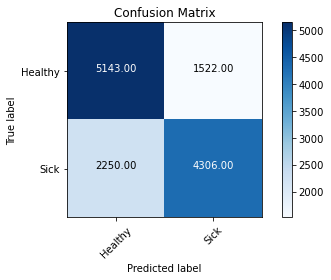

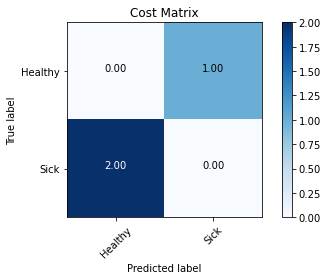

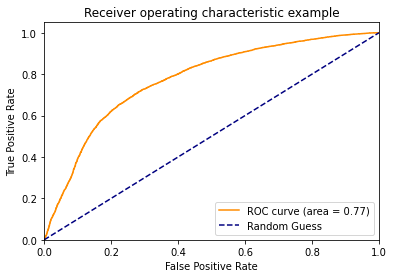


ROC Score:
0.7748512326373235


In [10]:
show_evaluation(y_test, y_pred, y_proba)

In [11]:
# Save predictions
method_name = 'Naïve Bayes'
predicted_probabilities = y_proba
savePredictedProbabilities(method_name, np.squeeze(y_test), predicted_probabilities)